In [ ]:
library(Seurat)
library(data.table)
library(Matrix)
library(future)
library(dplyr)
library(tidyr)
library(patchwork)
library(ggplot2)
library(ggrepel)
library(grid)
library(Matrix)
library(doParallel)
library(FNN)
library(edgeR)
library(harmony)
library(SeuratDisk)
library(spacexr)
library(glue)
library(scales)

In [2]:
options(future.globals.maxSize = 32000 * 1024^2)
plan("multicore", workers = 12)
plan()

multicore:
- args: function (..., workers = 12, envir = parent.frame())
- tweaked: TRUE
- call: plan("multicore", workers = 12)

### Preliminary analysis and integration

In [3]:
if (file.exists("data/cosmx_cHL.rds")) {
    nano.obj <- readRDS("data/cosmx_cHL.rds")
} else {
    nano.objs <- list()
    for (slide in c(1, 2, 3)) {
        nano.obj <- LoadNanostring(data.dir = paste0("data/Slide", slide), fov = "Slide")

        meta.data <- read.csv(paste0("data/Slide", slide, "/SMI-0026_Slide", slide, "_metadata_file.csv"))
        meta.data$id <- paste0(meta.data$cell_ID, "_", meta.data$fov)
        rownames(meta.data) <- meta.data$id
        meta.data <- cbind(meta.data[rownames(nano.obj@meta.data),], nano.obj@meta.data)
        nano.obj <- AddMetaData(nano.obj, metadata = meta.data)
        
        nano.obj@meta.data$slide = slide

        nano.obj@meta.data$patient = 2 * (slide - 1) + 1
        nano.obj@meta.data$patient[nano.obj@meta.data$CenterX_global_px < 0] = 2 * (slide - 1) + 2
        
        nano.obj$cell_filtering <- "remove"
        for(patient_id in unique(nano.obj@meta.data$patient)) {
            meta_sub <- nano.obj@meta.data[nano.obj$patient == patient_id,]
            nCount_Nanostring_low = as.numeric(quantile(meta_sub$nCount_Nanostring, prob=c(0.2)))
            print(paste0("Patient ", patient_id, " nCount_Nanostring > ", nCount_Nanostring_low))
            meta_sub <- meta_sub[meta_sub$nCount_Nanostring > nCount_Nanostring_low,]
            nano.obj$cell_filtering[colnames(nano.obj) %in% rownames(meta_sub)] <- "keep"
        }
        nano.obj <- subset(nano.obj, cell_filtering == "keep")

        nano.objs[[slide]] <- nano.obj
    }

    nano.obj <- merge(nano.objs[[1]], y = c(nano.objs[[2]], nano.objs[[3]]), 
                      add.cell.ids = c("1", "2", "3"), project = "cHL_spatial")
    
    print(dim(nano.obj))

    nano.obj[['Slide_1']] <- nano.obj[['Slide']]
    nano.obj[['Slide']] <- NULL
    
    nano.obj@meta.data$patient.fov <- paste0(nano.obj@meta.data$patient, ".", nano.obj@meta.data$fov)
    nano.obj@meta.data$condition <- "Lymph Node"
    nano.obj@meta.data$condition[nano.obj@meta.data$patient %in% c("2", "4","5","6")] <- "cHL"
    
    nano.obj <- subset(nano.obj, condition == 'cHL')
    nano.obj@meta.data$slide.fov <- paste0(nano.obj@meta.data$slide, ".", nano.obj@meta.data$fov)
        
    nano.obj <- SCTransform(nano.obj, assay = "Nanostring", clip.range = c(-10, 10), verbose = FALSE)
    
    DefaultAssay(nano.obj) <- "SCT"
    
    VariableFeatures(nano.obj) <- rownames(nano.obj) # use all features, we have few to begin withj)
    nano.obj <- RunPCA(nano.obj, npcs = 50, features = rownames(nano.obj))
    nano.obj <- RunHarmony(nano.obj, "slide.fov", assay.use="SCT")
    nano.obj <- RunUMAP(
        nano.obj, reduction='harmony', dims = 1:50, 
        spread=10, min.dist = 0.01, learning.rate=10, n.neighbors = 15L, n.epochs=1000
    )
    nano.obj <- FindNeighbors(nano.obj, reduction='harmony', dims = 1:50)
    nano.obj <- FindClusters(nano.obj, resolution = 0.5)
    
    markers <- read.csv("data/hrs_markers.csv")$x[read.csv("data/hrs_markers.csv")$x 
                                              %in% rownames(nano.obj@assays$Nanostring@counts)]
    markers <- c(markers, 'NFKBIA', 'STAT5A', 'IL6', 'CDKN1A', 'IER3','CD274')
    nano.obj@meta.data$hrs.markers.sum <- colSums(nano.obj@assays$Nanostring@counts[markers, ])
    
    ### Add RCTD results
    doublet.RCTDs <- lapply(paste0("data/RCTD_cosmx_patient_", unique(nano.obj@meta.data$patient),".rds"), f
                            unction(s) readRDS(s)@results$results_df)
    doublet.RCTD <- do.call(rbind.data.frame, doublet.RCTDs)
    doublet.RCTD <- doublet.RCTD[rownames(nano.obj@meta.data),]
    nano.obj <- AddMetaData(nano.obj, metadata = doublet.RCTD)
    
    full.RCTD <- readRDS('data/RCTD_cosmx_cHL.rds')
    nano.obj <- AddMetaData(nano.obj, metadata = as.data.frame(full.RCTD@results$weights))
                            
    nano.obj@meta.data$first_type <- as.character(nano.obj@meta.data$first_type)
    nano.obj@meta.data$second_type <- as.character(nano.obj@meta.data$second_type)
    nano.obj@meta.data$spot_class <- as.character(nano.obj@meta.data$spot_class)
    
    ### Save
    nano.obj@images$Slide_1 <- NULL
    nano.obj@images$Slide_2 <- NULL
    nano.obj@images$Slide_3 <- NULL
    
    saveRDS(nano.obj, "data/cosmx_cHL.rds")

}
nano.obj

An object of class Seurat 
1956 features across 317442 samples within 2 assays 
Active assay: SCT (978 features, 978 variable features)
 1 other assay present: Nanostring
 4 dimensional reductions calculated: pca, harmony, umap, tsne

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for y is already present.
Adding another scale for y, which will replace the
existing scale.
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for y is already present.
Adding another scale for y, which will replace the
existing scale.


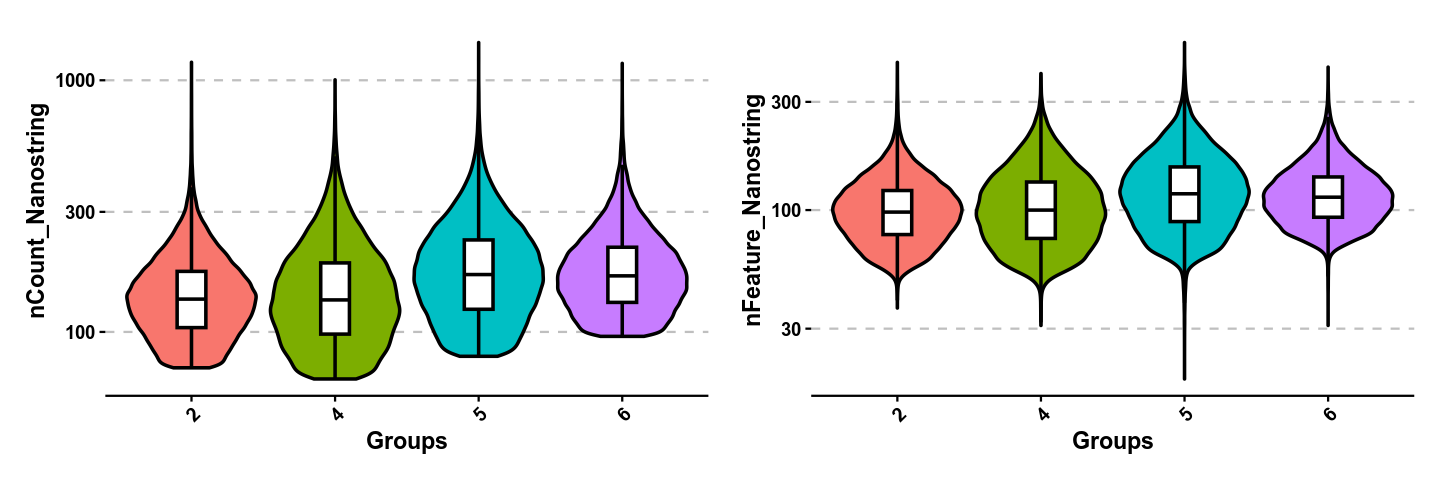

In [27]:
options(repr.plot.width=12, repr.plot.height=4)
colors <- hue_pal()(4)
names(colors) <- unique(nano.obj[['patient']])$patient

p1 <- SCpubr::do_ViolinPlot(
    sample = nano.obj, 
    feature = c("nCount_Nanostring"), 
    group.by = "patient", 
    colors.use=as.list(colors)
) + scale_y_continuous(trans='log10')

p2 <- SCpubr::do_ViolinPlot(
    sample = nano.obj, 
    feature = c("nFeature_Nanostring"), 
    group.by = "patient", 
    colors.use=as.list(colors)
) + scale_y_continuous(trans='log10')

p1 | p2

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


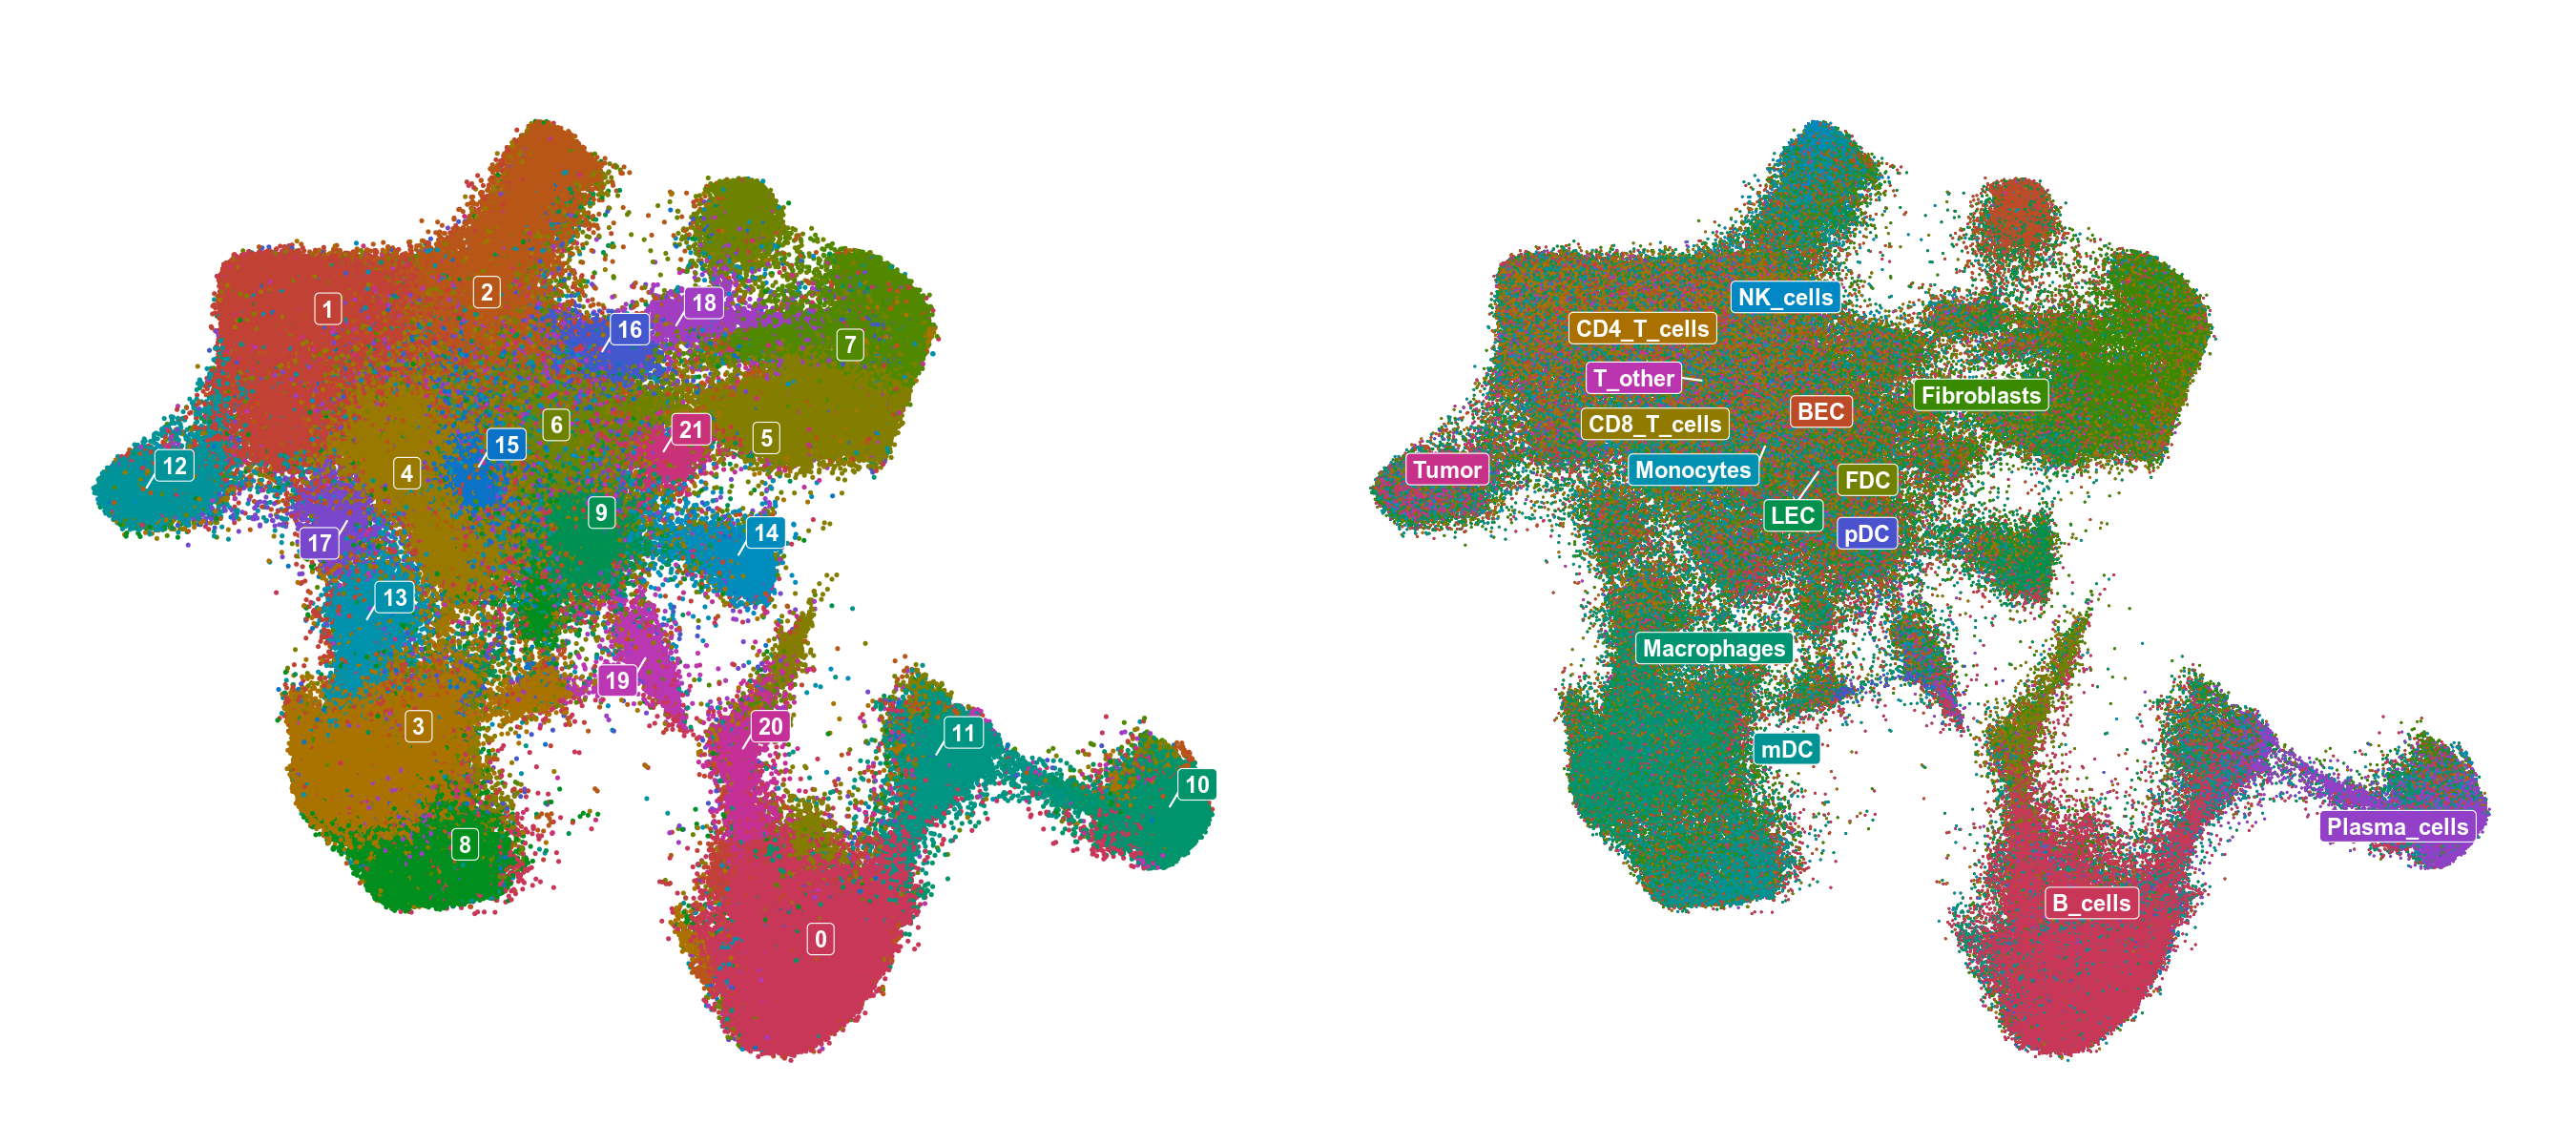

In [70]:
options(repr.plot.width=18, repr.plot.height=8)
p1 <- SCpubr::do_DimPlot(
    sample=nano.obj, 
    group.by='clusters', 
    shuffle=FALSE, 
    pt.size=.5, 
    label=TRUE, 
    border.size=.25
) + NoLegend()

p2 <- SCpubr::do_DimPlot(
    sample=nano.obj, 
    group.by='first_type', 
    shuffle=FALSE, 
    pt.size=.05, 
    label=TRUE, 
    border.size=.025
) + NoLegend()

p1 | p2 

In [57]:
new.cluster.ids <- c(
    'B_cells','CD4_T_cells','NK_cells','Mono/macs','CD8_T_cells','Fibroblasts','BEC','Fibroblasts',
    'mDC','Epithelium_KRT16+','Plasma_cells ','Plasma_cells ','Tumor','Mono/macs','LEC','CD4_T_cells',
    'CD4_T_cells','CD4_T_cells','CD4_T_cells','CD4_T_cells','B_cells','Fibroblasts'
)
names(new.cluster.ids) <- seq(0, length(levels(Idents(nano.obj)))-1)

In [58]:
nano.obj$cell_types_level_3 <- as.character(new.cluster.ids[as.character(nano.obj$clusters)])
table(nano.obj$cell_types_level_3)


          B_cells               BEC       CD4_T_cells       CD8_T_cells 
            47451             20111             62175             21212 
Epithelium_KRT16+       Fibroblasts               LEC               mDC 
            12092             38642              8683             12345 
        Mono/macs          NK_cells     Plasma_cells              Tumor 
            34008             27064             22900             10759 

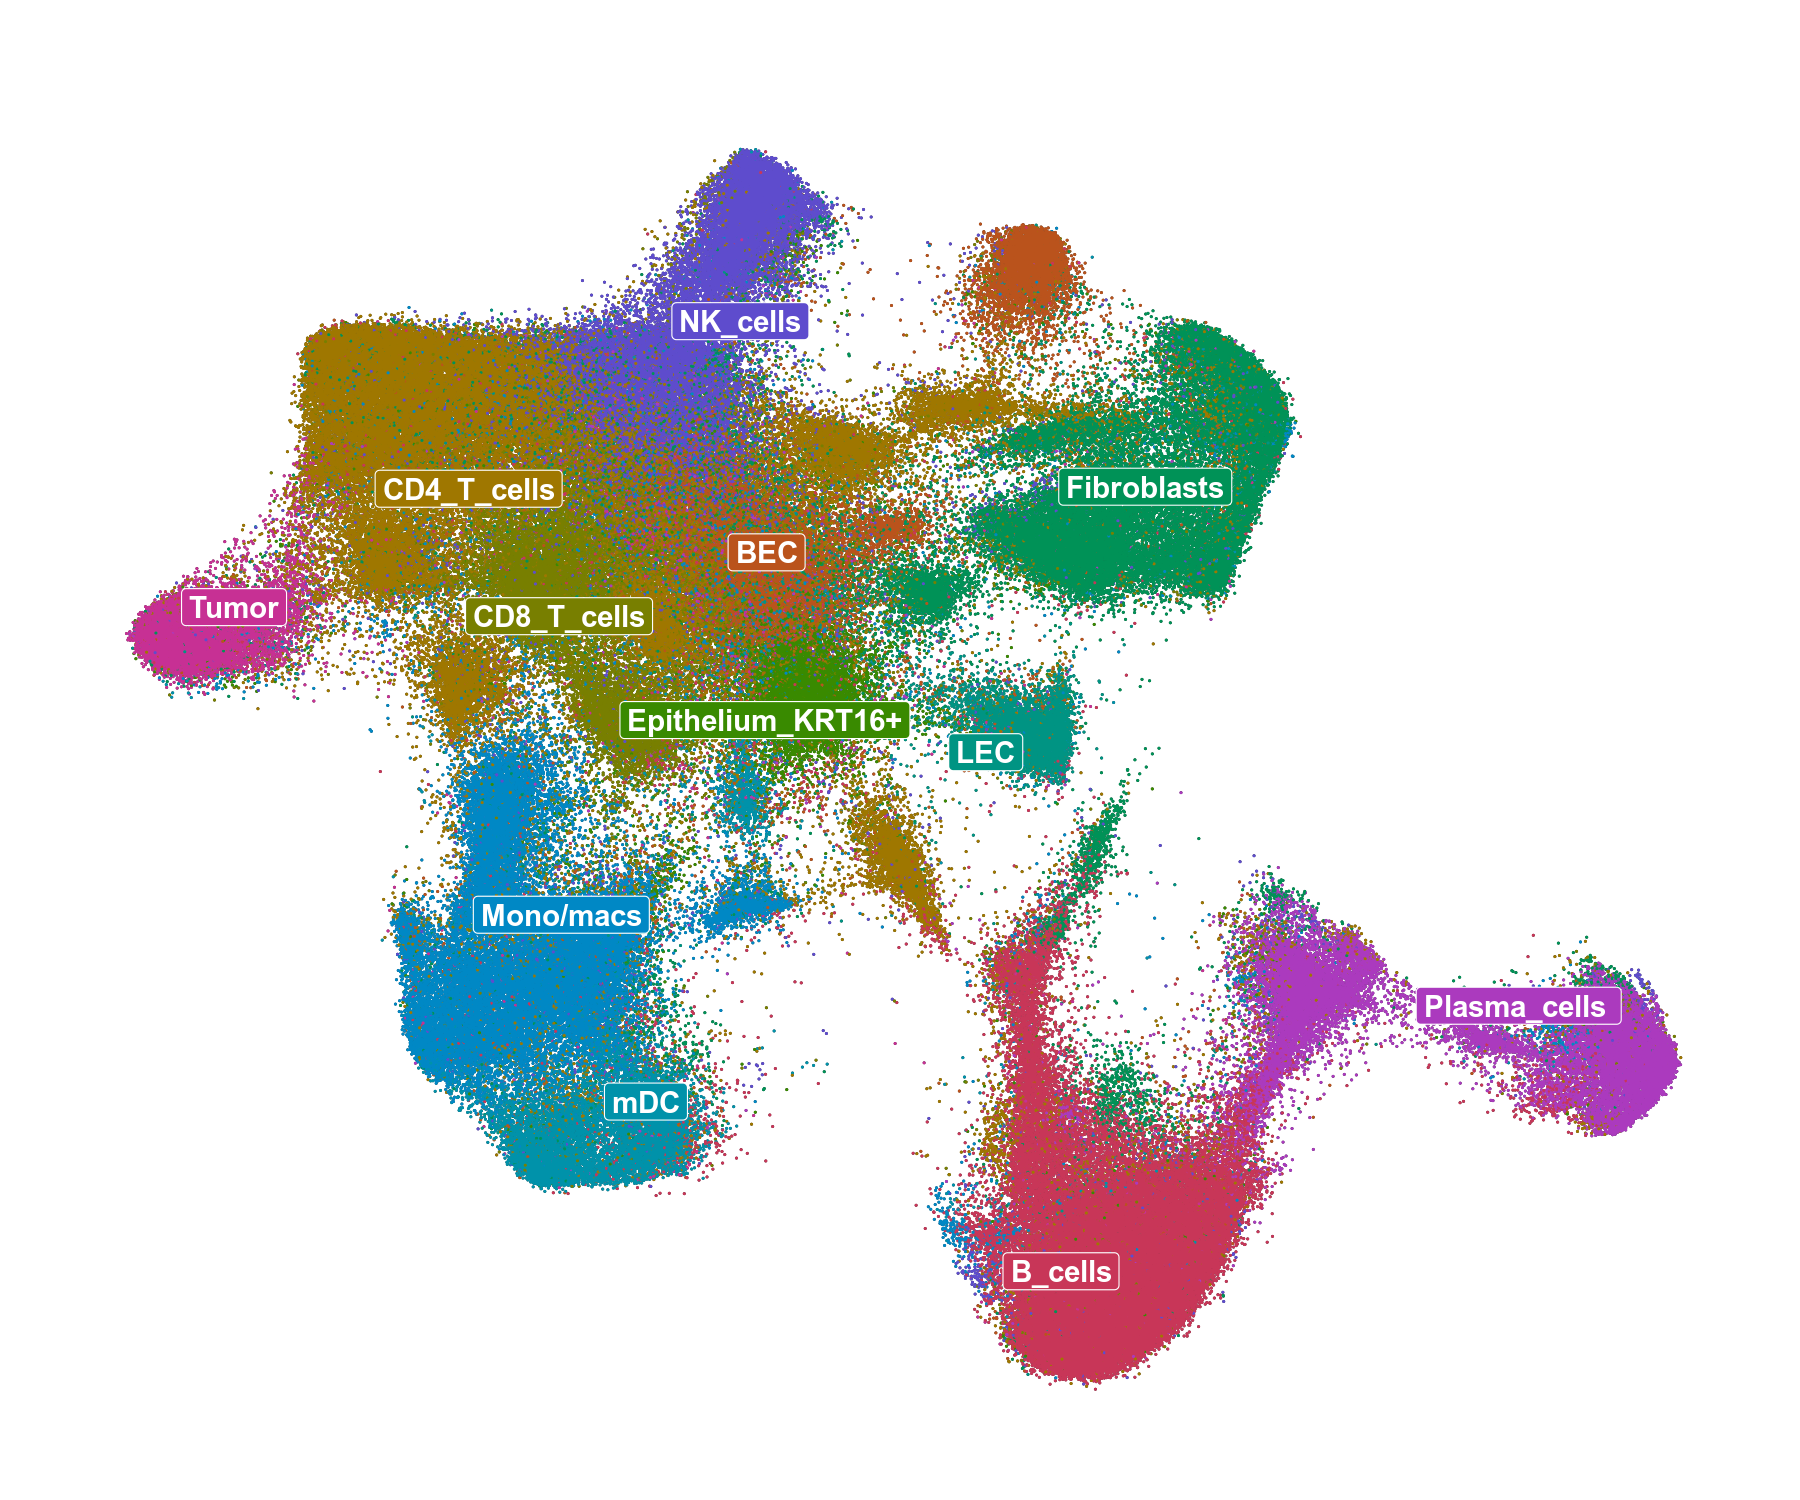

In [71]:
options(repr.plot.width=12, repr.plot.height=10, repr.plot.res=150)
p1 <- SCpubr::do_DimPlot(
    sample=nano.obj, 
    group.by='cell_types_level_3', 
    shuffle=FALSE, 
    pt.size=.05, 
    label=TRUE, 
    border.size=.025
) + NoLegend()
p1$layers[[length(p1$layers)]]$aes_params$size <- 5
p1 

### Save

In [65]:
nano.obj@images$Slide_1 <- NULL
nano.obj@images$Slide_2 <- NULL
nano.obj@images$Slide_3 <- NULL

In [66]:
nano.obj

An object of class Seurat 
1956 features across 317442 samples within 2 assays 
Active assay: SCT (978 features, 978 variable features)
 1 other assay present: Nanostring
 4 dimensional reductions calculated: pca, harmony, umap, tsne

In [ ]:
saveRDS(nano.obj, "data/cosmx_cHL.rds")
SaveH5Seurat(nano.obj, "data/cosmx_cHL.h5Seurat", overwrite = TRUE)
Convert("data/cosmx_cHL.h5Seurat", dest = "h5ad", overwrite=TRUE)

### Session

In [242]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS/LAPACK: /home/dchafamo/anaconda3/envs/muscat2/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] parallel  grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] spacexr_2.0.7         SeuratDisk_0.0.0.9020 harmony_0.1.1        
 [4] Rcpp_1.0.9            edgeR_3.36.0          limma_3.50.3         
 [7] FNN_1.1.3.1           doParallel_1.0.17     iterators_1.0.14     
[10] foreach_1.5.2         ggrepel_0.9.2         ggplot2_3.4.0        
[13] patchwork_1.1.2       tidyr_1.2.1  